<a href="https://colab.research.google.com/github/iamdsc/humor_detection/blob/master/humor_detection_with_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Humor Detection (Deep Learning using Keras)

In [ ]:
# required imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,Flatten,Dense,Dropout,SimpleRNN,LSTM,Conv1D,MaxPooling1D,GlobalMaxPooling1D,GRU
from keras.optimizers import RMSprop
from keras import backend as K

## Getting the data

In [ ]:
# Load in the dataset
!git clone https://github.com/fowiny/humor_detection

Cloning into 'humor_detection'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 48 (delta 0), reused 0 (delta 0), pack-reused 43
Unpacking objects: 100% (48/48), done.


In [ ]:
%cd humor_detection/datasets
!ls

/content/humor_detection/datasets
humorous_oneliners.pickle      reuters_headlines.pickle  wiki_sentences.pickle
oneliners_incl_doubles.pickle  stopwords.txt
proverbs.pickle		       train_humour.csv


## Loading the dataset

In [ ]:
df = pd.read_csv('train_humour.csv')
df.head(3)

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4


## Remove punctuations

In [ ]:
import re

def remove_punctuations(sent):
  clean = re.sub(r"""
                [!#$%&()*+,-:/;\[\]<=>?@_\\{|}~\"]+  # Accept one or more copies of punctuation
                \ *                                 # plus zero or more copies of a space,
                """,
                " ",          # and replace it with a single space
                sent, flags=re.VERBOSE)
  return (clean)

In [111]:
text_noPuncs = df.text.apply(remove_punctuations).str.strip()
df['text_noPuncs'] = text_noPuncs
df.head()

,id,text,is_humor,humor_rating,humor_controversy,offense_rating,text_noPuncs,text_noStops
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2,TENNESSEE We're the best state Nobody even com...,TENNESSEE We're the best state Nobody even com...
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1,A man inserted an advertisement in the classif...,A man inserted an advertisement in the classif...
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4,How many men does it take to open a can of bee...,How many men does it take to open a can of bee...
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0,Told my mom I hit Twitter followers She point...,Told my mom I hit Twitter followers She point...
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1,Roses are dead Love is fake Weddings are basic...,Roses are dead Love is fake Weddings are basic...


## Stopwords

In [ ]:
with open('stopwords.txt') as f:
    stop_words = [line.rstrip() for line in f]



def stopworder(df):
    stop_list = df.apply(lambda x: [item for item in x.split() if item.lower() not in stop_words])
    stop_sentence = stop_list.apply(lambda x : " ".join(x))
    return (stop_sentence)

In [ ]:
text_noStops = stopworder(df['text_noPuncs'])
df['text_noStops'] = text_noPuncs
df.head()

,id,text,is_humor,humor_rating,humor_controversy,offense_rating,text_noPuncs,text_noStops
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2,TENNESSEE We're the best state Nobody even com...,TENNESSEE We're the best state Nobody even com...
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1,A man inserted an advertisement in the classif...,A man inserted an advertisement in the classif...
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4,How many men does it take to open a can of bee...,How many men does it take to open a can of bee...
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0,Told my mom I hit Twitter followers She point...,Told my mom I hit Twitter followers She point...
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1,Roses are dead Love is fake Weddings are basic...,Roses are dead Love is fake Weddings are basic...


## word2vec

In [ ]:
# Creating word vectors
from gensim.models import Word2Vec

text = df['text_noStops'].str.lower().str.split().to_list()
w2v = Word2Vec(text, min_count=1)

In [ ]:
# building list of sentence vectors
vect_record=[]
for sent in df['text_noStops'].to_list():
  if len(sent)!=0:
    sent_vect = sum([w2v[w] for w in sent.lower().split()])/(len(sent.split())+0.001)
  else:  
    sent_vect = np.zeros((100,))
  vect_record.append(sent_vect)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [ ]:
#vect_record_ser = df['text_noStops'].str.lower().str.split().apply(lambda sentence: sum([w2v[w] for w in sentence])/\
#            (len(sentence)+0.001) if len(sentence)!=0 else np.zeros((100,)))

vect_record_ser = df['text_noStops'].str.lower().str.split().apply(lambda sentence: sum([w2v[w] for w in sentence]) \
                                                         if len(sentence)!=0 else np.zeros((100,)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [ ]:
X = pd.DataFrame(vect_record_ser.to_list(), columns=range(100))
print(X.head())
print(X.shape)


y = df['is_humor']
print('\n')
print(y[:5])

         0         1         2   ...        97        98        99
0  0.225790 -0.044686 -0.109939  ... -0.366396  0.048042  0.732660
1  0.293498 -0.069810 -0.161452  ... -0.517464  0.048129  1.053527
2  0.339688 -0.124441 -0.235500  ... -0.614236  0.038249  1.336822
3  0.205069 -0.054766 -0.121971  ... -0.475474  0.036723  0.934975
4  0.207216 -0.080860 -0.160716  ... -0.401004  0.005947  0.834422

[5 rows x 100 columns]
(8000, 100)


0    1
1    1
2    1
3    1
4    1
Name: is_humor, dtype: int64


### Train, test split

In [ ]:
# Performaing train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)



print('Training Data: ', X_train.shape, y_train.shape)
print('Test Data: ', X_test.shape, y_test.shape)

Training Data:  (6400, 100) (6400,)
Test Data:  (1600, 100) (1600,)


## SVM

In [ ]:
from sklearn.svm import SVC

# fit the SVM model with linear Kernel
svm = SVC(kernel='linear', random_state=1, C=1.0)
svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
# performing prediction in test samples
y_pred = svm.predict(X_test)
print(y_pred[:5])

[1 0 0 1 1]


In [ ]:
# Calculating Classification Accuracy
from sklearn.metrics import accuracy_score

print('Test Accuracy Score: ',accuracy_score(y_pred, y_test))

Test Accuracy Score:  0.74125


In [ ]:
# Calculating Cross Validation Accuracy
from sklearn.model_selection import cross_val_score
import numpy as np

scores = cross_val_score(estimator=svm, X=X_train, y=y_train, cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f'%(np.mean(scores),np.std(scores)))

CV accuracy: 0.789 +/- 0.016


## Logistic Regression

In [ ]:
# Using Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(X_train, y_train)

# performing prediction on test samples
y_pred = lr.predict(X_test)

print('Test Accuracy score: ', accuracy_score(y_pred, y_test))

scores = cross_val_score(estimator=lr, X=X_train, y=y_train, cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f'%(np.mean(scores),np.std(scores)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Test Accuracy score:  0.765625
CV accuracy: 0.767 +/- 0.011


# APPLY DEEP LEARNING

## Pre-processing the dataset

In [112]:
# Tokenizing the data
maxlen = 60 # cut off sentences after 50 words
#max_words = 15000 # only consider top 10000 common words in dataset
max_words = 10000 # only consider top 10000 common words in dataset

texts = df['text'].to_list()

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print('Found %s unique tokens'%len(word_index))

# padding the sequences
data = pad_sequences(sequences, maxlen=maxlen)

labels = df['is_humor'].to_numpy()

print('Shape of data tensor:',data.shape)
print('Shape of labels tensor:',labels.shape)

# shuffle the data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Found 15392 unique tokens
Shape of data tensor: (8000, 60)
Shape of labels tensor: (8000,)


## Loading the pre-trained word embeddings

In [113]:
# due to small size of dataset
# we would use standford's GloVe pre-trained word embeddings

# download the GloVe word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-12-15 19:31:18--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-12-15 19:31:18--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-12-15 19:31:18--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [114]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.50d.txt        
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.100d.txt       
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.200d.txt       
replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.300d.txt       


In [115]:
# parsing the GloVe word-embeddings file
embeddings_index = {}

f = open('glove.6B.100d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors:'%len(embeddings_index))

# preparing glove word embeddings matrix
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i<max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector # for words not in embedding index values will be zeros

Found 400000 word vectors:


## Building the model

### 1. Simple feed-forward network with dense layers on top of embedding layer 

In [116]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3)) # adding regularization

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 60, 100)           1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 6000)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                384064    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 1,384,129
Trainable params: 1,384,129
Non-trainable params: 0
_________________________________________________________________


In [117]:
# load pre-trained word embeddings into the embedding layer and freeze it
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [118]:
# to compute fmeasure as custom metric
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [119]:
# train the model
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics = ['acc', f1])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
225/225 [==============================] - 1s 4ms/step - loss: 0.5766 - acc: 0.7001 - f1: 0.7821 - val_loss: 0.5109 - val_acc: 0.7375 - val_f1: 0.8048
Epoch 2/20
225/225 [==============================] - 1s 3ms/step - loss: 0.4691 - acc: 0.7785 - f1: 0.8279 - val_loss: 0.4805 - val_acc: 0.7613 - val_f1: 0.8136
Epoch 3/20
225/225 [==============================] - 1s 3ms/step - loss: 0.4075 - acc: 0.8144 - f1: 0.8539 - val_loss: 0.4642 - val_acc: 0.7775 - val_f1: 0.8289
Epoch 4/20
225/225 [==============================] - 1s 3ms/step - loss: 0.3723 - acc: 0.8401 - f1: 0.8722 - val_loss: 0.4541 - val_acc: 0.7812 - val_f1: 0.8298
Epoch 5/20
225/225 [==============================] - 1s 3ms/step - loss: 0.3482 - acc: 0.8536 - f1: 0.8829 - val_loss: 0.4479 - val_acc: 0.7875 - val_f1: 0.8278
Epoch 6/20
225/225 [==============================] - 1s 3ms/step - loss: 0.3227 - acc: 0.8689 - f1: 0.8938 - val_loss: 0.4498 - val_acc: 0.7887 - val_f1: 0.8264
Epoch 7/20
225/225 [========

In [120]:
# helper function to plot the results
def plot_result(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  f1 = history.history['f1']
  val_f1 = history.history['val_f1']
  
  epochs = range(1, len(acc)+1)

  plt.plot(epochs, acc, label='Training acc')
  plt.plot(epochs, val_acc, label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('epochs')
  plt.ylabel('acc')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()

  plt.figure()

  plt.plot(epochs, f1, label='Training fmeasure')
  plt.plot(epochs, val_f1, label='Validation fmeasure')
  plt.title('Training and validation fmeasure')
  plt.xlabel('epochs')
  plt.ylabel('f1')
  plt.legend()
  
  plt.show()

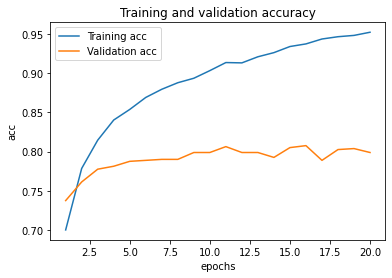

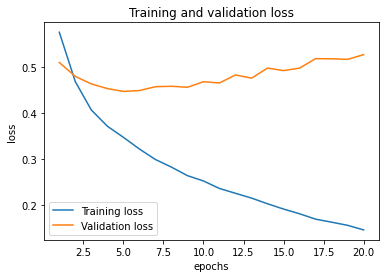

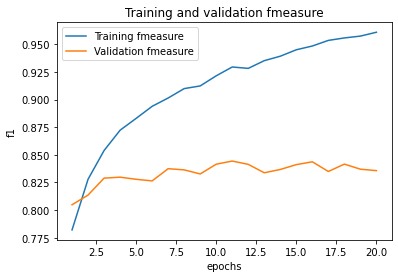

In [121]:
# plotting the results
plot_result(history)

In [122]:
# Building model without pre-trained word embeddings

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3)) # adding regularization

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics = ['acc', f1])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 60, 100)           1000000   
_________________________________________________________________
flatten_5 (Flatten)          (None, 6000)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                384064    
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 1,384,129
Trainable params: 1,384,129
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
225/225 [==============================] - 2s 7ms/step - loss: 0.6578 - acc: 0.6242 - f1: 0.7577 -

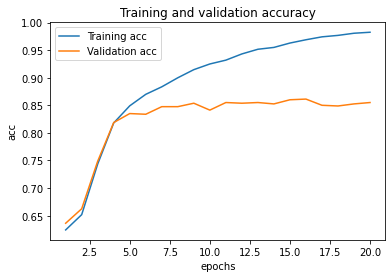

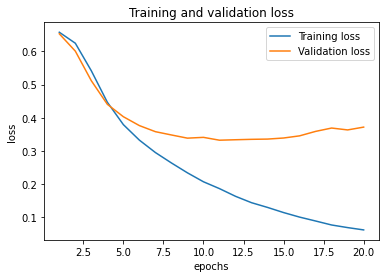

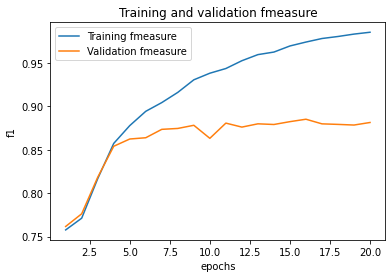

In [123]:
plot_result(history)

### 2. Using Simple RNN layer on top of embedding layer

In [124]:
model = Sequential()
model.add(Embedding(max_words, 32))
model.add(SimpleRNN(64, dropout=0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 64)                6208      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 326,273
Trainable params: 326,273
Non-trainable params: 0
_________________________________________________________________


In [125]:
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc', f1])
history = model.fit(data,labels, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
225/225 [==============================] - 8s 37ms/step - loss: 0.6580 - acc: 0.6297 - f1: 0.7616 - val_loss: 0.6501 - val_acc: 0.6363 - val_f1: 0.7633
Epoch 2/20
225/225 [==============================] - 8s 36ms/step - loss: 0.6096 - acc: 0.6731 - f1: 0.7684 - val_loss: 0.5703 - val_acc: 0.6825 - val_f1: 0.7775
Epoch 3/20
225/225 [==============================] - 8s 36ms/step - loss: 0.5173 - acc: 0.7521 - f1: 0.8069 - val_loss: 0.4833 - val_acc: 0.7975 - val_f1: 0.8328
Epoch 4/20
225/225 [==============================] - 8s 36ms/step - loss: 0.4466 - acc: 0.7985 - f1: 0.8377 - val_loss: 0.4539 - val_acc: 0.7900 - val_f1: 0.8406
Epoch 5/20
225/225 [==============================] - 8s 36ms/step - loss: 0.3976 - acc: 0.8256 - f1: 0.8555 - val_loss: 0.4098 - val_acc: 0.8200 - val_f1: 0.8502
Epoch 6/20
225/225 [==============================] - 8s 36ms/step - loss: 0.3630 - acc: 0.8440 - f1: 0.8706 - val_loss: 0.3904 - val_acc: 0.8325 - val_f1: 0.8612
Epoch 7/20
225/225 [==

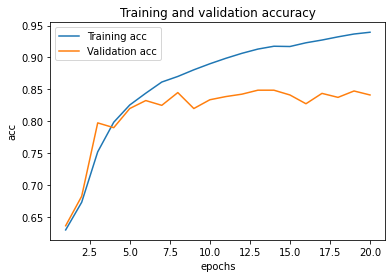

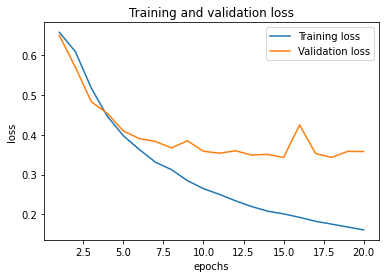

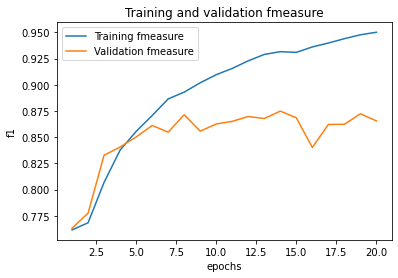

In [126]:
plot_result(history)

### 3. Using LSTM layer on top of the embedding layer

In [127]:
model = Sequential()
model.add(Embedding(max_words, 32))
model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 344,897
Trainable params: 344,897
Non-trainable params: 0
_________________________________________________________________


In [128]:
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc', f1])
history = model.fit(data, labels, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
200/200 [==============================] - 21s 104ms/step - loss: 0.6729 - acc: 0.6130 - f1: 0.7552 - val_loss: 0.6586 - val_acc: 0.6144 - val_f1: 0.7578
Epoch 2/30
200/200 [==============================] - 21s 104ms/step - loss: 0.6473 - acc: 0.6170 - f1: 0.7599 - val_loss: 0.6316 - val_acc: 0.6144 - val_f1: 0.7578
Epoch 3/30
200/200 [==============================] - 20s 101ms/step - loss: 0.6035 - acc: 0.6212 - f1: 0.7616 - val_loss: 0.5635 - val_acc: 0.6413 - val_f1: 0.7709
Epoch 4/30
200/200 [==============================] - 20s 102ms/step - loss: 0.5431 - acc: 0.6889 - f1: 0.7944 - val_loss: 0.5091 - val_acc: 0.7306 - val_f1: 0.8134
Epoch 5/30
200/200 [==============================] - 21s 104ms/step - loss: 0.4956 - acc: 0.7695 - f1: 0.8347 - val_loss: 0.4798 - val_acc: 0.7994 - val_f1: 0.8454
Epoch 6/30
200/200 [==============================] - 20s 102ms/step - loss: 0.4572 - acc: 0.8127 - f1: 0.8570 - val_loss: 0.4480 - val_acc: 0.8119 - val_f1: 0.8497
Epoch 7/30

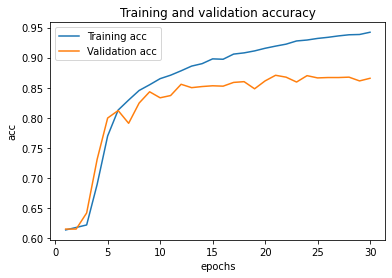

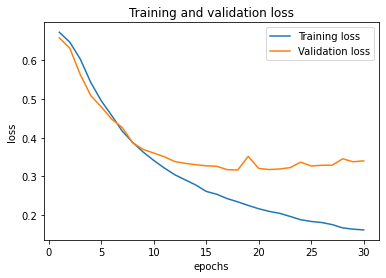

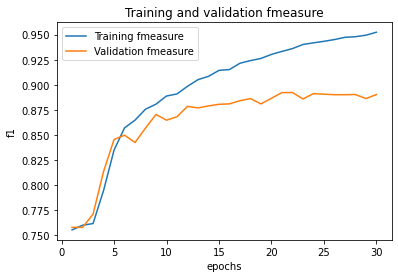

In [129]:
plot_result(history)

### 3. Using two Conv1D layers on top of the Embedding layer

In [130]:
model = Sequential()
model.add(Embedding(max_words, 32))

model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(5))

model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 64)          10304     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 335,521
Trainable params: 335,521
Non-trainable params: 0
_______________________________________________

In [131]:
# train the model
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc', f1])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
225/225 [==============================] - 1s 5ms/step - loss: 0.6706 - acc: 0.6136 - f1: 0.7545 - val_loss: 0.6626 - val_acc: 0.6087 - val_f1: 0.7539
Epoch 2/20
225/225 [==============================] - 1s 5ms/step - loss: 0.6509 - acc: 0.6174 - f1: 0.7597 - val_loss: 0.6487 - val_acc: 0.6087 - val_f1: 0.7539
Epoch 3/20
225/225 [==============================] - 1s 5ms/step - loss: 0.6232 - acc: 0.6174 - f1: 0.7597 - val_loss: 0.6117 - val_acc: 0.6087 - val_f1: 0.7539
Epoch 4/20
225/225 [==============================] - 1s 5ms/step - loss: 0.5664 - acc: 0.6575 - f1: 0.7795 - val_loss: 0.5486 - val_acc: 0.7150 - val_f1: 0.8026
Epoch 5/20
225/225 [==============================] - 1s 5ms/step - loss: 0.4941 - acc: 0.7878 - f1: 0.8418 - val_loss: 0.4893 - val_acc: 0.7825 - val_f1: 0.8246
Epoch 6/20
225/225 [==============================] - 1s 5ms/step - loss: 0.4336 - acc: 0.8278 - f1: 0.8618 - val_loss: 0.4465 - val_acc: 0.7950 - val_f1: 0.8353
Epoch 7/20
225/225 [========

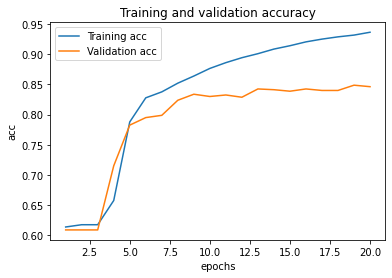

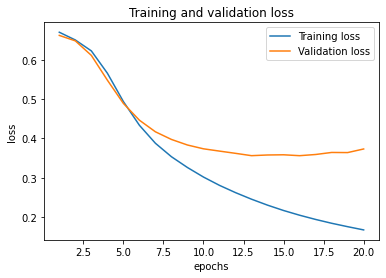

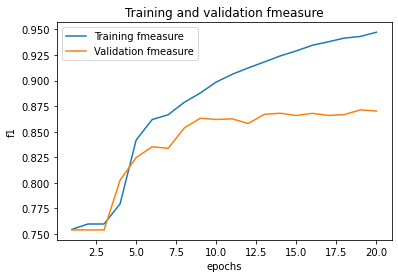

In [132]:
# plot the results
plot_result(history)

### 4. Using LSTM layer on top of Conv1D layer

In [133]:
model = Sequential()
model.add(Embedding(max_words, 32))

model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(5))

model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 350,049
Trainable params: 350,049
Non-trainable params: 0
_________________________________________________________________


In [134]:
# train the model
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc', f1])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
225/225 [==============================] - 5s 23ms/step - loss: 0.6700 - acc: 0.6174 - f1: 0.7595 - val_loss: 0.6641 - val_acc: 0.6087 - val_f1: 0.7539
Epoch 2/20
225/225 [==============================] - 5s 22ms/step - loss: 0.6534 - acc: 0.6174 - f1: 0.7596 - val_loss: 0.6526 - val_acc: 0.6087 - val_f1: 0.7539
Epoch 3/20
225/225 [==============================] - 5s 22ms/step - loss: 0.6293 - acc: 0.6176 - f1: 0.7603 - val_loss: 0.6166 - val_acc: 0.6125 - val_f1: 0.7557
Epoch 4/20
225/225 [==============================] - 5s 22ms/step - loss: 0.5698 - acc: 0.6425 - f1: 0.7717 - val_loss: 0.5459 - val_acc: 0.6862 - val_f1: 0.7901
Epoch 5/20
225/225 [==============================] - 5s 22ms/step - loss: 0.4981 - acc: 0.7531 - f1: 0.8245 - val_loss: 0.4880 - val_acc: 0.7675 - val_f1: 0.8189
Epoch 6/20
225/225 [==============================] - 5s 22ms/step - loss: 0.4423 - acc: 0.8076 - f1: 0.8488 - val_loss: 0.4440 - val_acc: 0.7862 - val_f1: 0.8283
Epoch 7/20
225/225 [==

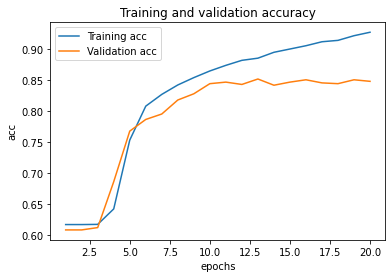

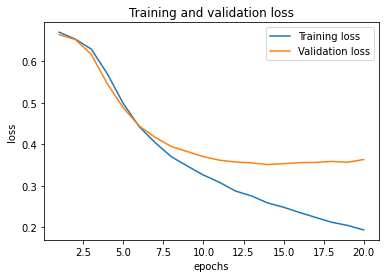

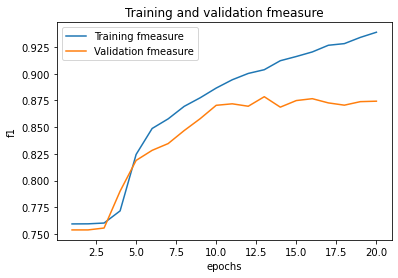

In [135]:
# plot the results
plot_result(history)

### 5. Using GRU layer on top of Conv1D layer

In [136]:
model = Sequential()
model.add(Embedding(max_words, 32))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
conv1d_15 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
gru_6 (GRU)                  (None, 64)                18816     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 65        
Total params: 344,033
Trainable params: 344,033
Non-trainable params: 0
_________________________________________________________________


In [137]:
# train the model
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc', f1])
history = model.fit(data, labels, epochs=30, batch_size=32, validation_split=0.1)

Epoch 1/30
225/225 [==============================] - 5s 22ms/step - loss: 0.6792 - acc: 0.6154 - f1: 0.7540 - val_loss: 0.6700 - val_acc: 0.6087 - val_f1: 0.7539
Epoch 2/30
225/225 [==============================] - 5s 21ms/step - loss: 0.6605 - acc: 0.6174 - f1: 0.7598 - val_loss: 0.6609 - val_acc: 0.6087 - val_f1: 0.7539
Epoch 3/30
225/225 [==============================] - 5s 21ms/step - loss: 0.6464 - acc: 0.6174 - f1: 0.7602 - val_loss: 0.6415 - val_acc: 0.6087 - val_f1: 0.7539
Epoch 4/30
225/225 [==============================] - 5s 21ms/step - loss: 0.6104 - acc: 0.6178 - f1: 0.7598 - val_loss: 0.5926 - val_acc: 0.6175 - val_f1: 0.7580
Epoch 5/30
225/225 [==============================] - 5s 21ms/step - loss: 0.5410 - acc: 0.7017 - f1: 0.7993 - val_loss: 0.5185 - val_acc: 0.7387 - val_f1: 0.8138
Epoch 6/30
225/225 [==============================] - 5s 20ms/step - loss: 0.4628 - acc: 0.8049 - f1: 0.8490 - val_loss: 0.4566 - val_acc: 0.8012 - val_f1: 0.8369
Epoch 7/30
225/225 [==

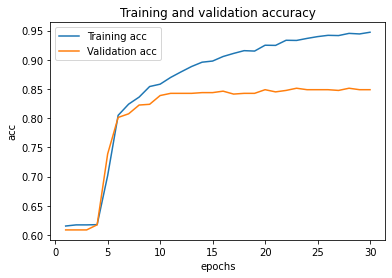

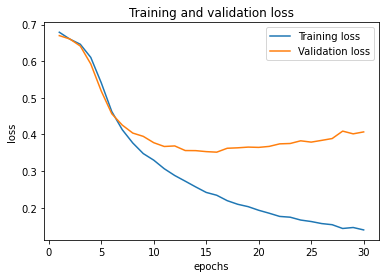

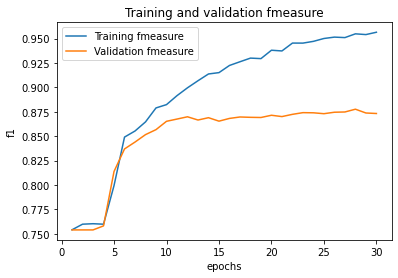

In [138]:
# plot the results
plot_result(history)

### 6. Using two GRU layers on top of two Conv1D layers

In [139]:
model = Sequential()
model.add(Embedding(max_words, 32))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(GRU(32, activation='relu', dropout=0.1, recurrent_dropout=0.5, return_sequences=True))
model.add(GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
conv1d_16 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, None, 64)          10304     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, None, 64)          0         
_________________________________________________________________
gru_7 (GRU)                  (None, None, 32)          9408      
_________________________________________________________________
gru_8 (GRU)                  (None, 64)              

In [140]:
# train the model
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc', f1])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
225/225 [==============================] - 2s 11ms/step - loss: 0.6810 - acc: 0.6174 - f1: 0.7600 - val_loss: 0.6696 - val_acc: 0.6087 - val_f1: 0.7539
Epoch 2/20
225/225 [==============================] - 2s 9ms/step - loss: 0.6644 - acc: 0.6174 - f1: 0.7600 - val_loss: 0.6664 - val_acc: 0.6087 - val_f1: 0.7539
Epoch 3/20
225/225 [==============================] - 2s 9ms/step - loss: 0.6610 - acc: 0.6174 - f1: 0.7598 - val_loss: 0.6654 - val_acc: 0.6087 - val_f1: 0.7539
Epoch 4/20
225/225 [==============================] - 2s 9ms/step - loss: 0.6573 - acc: 0.6174 - f1: 0.7598 - val_loss: 0.6586 - val_acc: 0.6087 - val_f1: 0.7539
Epoch 5/20
225/225 [==============================] - 2s 9ms/step - loss: 0.6465 - acc: 0.6174 - f1: 0.7597 - val_loss: 0.6414 - val_acc: 0.6087 - val_f1: 0.7539
Epoch 6/20
225/225 [==============================] - 2s 9ms/step - loss: 0.6153 - acc: 0.6178 - f1: 0.7598 - val_loss: 0.5993 - val_acc: 0.6200 - val_f1: 0.7593
Epoch 7/20
225/225 [=======

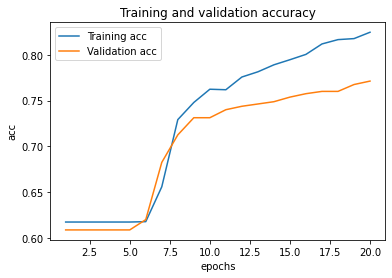

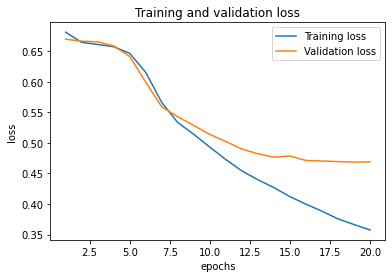

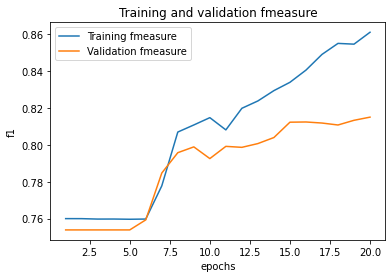

In [141]:
# plot the results
plot_result(history)